In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

# Teaching a small transformer the cellular automaton rule 54

The goal of this notebook is to explain the dynamics of a particular reversible cellular automaton called rule 54 (in the following abbreviated as CA54). A cellular automaton is a simple model of computation that takes place on a 2D grid. It will help to think of this grid as a stack of 1D binary chains; the first chain in the stack is the initial configuration and the axis along which the chains are stacked is the time axis. The chain configuration evolves according to the update rule.

Every site $s$ of the chain is updated based on its left neighbor $s_l$ and right neighbor $s_r$ as follows:
$$
s(t+1/2) = (s_l(t)+s(t)+s_r(t)+s_l(t)s_r(t))(\textrm{mod} 2).
$$
Importantly, a single time step is composed of two half steps: This rule is first applied to every even-index site, then to every odd-index site. Note that we will only consider chains of even length. It is easier to see how this works in code:


In [2]:
def step(arr):
    """Performs one full CA54 update step on the chain."""
    arr = np.array(arr)
    assert all(a==0 or a==1 for a in arr)
    # s(t+1/2) = (s_l(t) + s(t) + s_r(t) + s_l(t) s_r(t))(mod2) ≡ χ(s_l, s, s_r)
    chi = lambda arr,i: ( arr[i-1] + arr[i] + arr[(i+1)%len(arr)] + arr[(i+1)%len(arr)] * arr[i-1] )%2

    for i in range(0,len(arr),2): # update even sites first
        arr[i] = chi(arr,i)

    for i in range(1,len(arr),2): # update odd sites
        arr[i] = chi(arr,i)
    
    return torch.Tensor(arr).long()

Here's a snippet that shows us what the step function does:

In [3]:
gen_bin = lambda l: np.random.randint(0,2,(l,)) # generate a random binary chain of length l
arr = gen_bin(12)
print(arr,'->',step(arr).tolist())

[0 1 0 0 0 1 0 0 1 1 0 1] -> [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]


Implicitly, the rule above respects periodic boundary conditions (PBC), meaning we should think about these chains as really being circles, and when we plot the grids formed by subsequent application of the step() function, the 2D plot should be thought of as the unwrapped surface of a cylinder, where the height of the cylinder is the time axis. We use the data_gen() function to form these grids:

In [4]:
def data_gen(x, steps):
    out = [torch.tensor(x) if isinstance(x,np.ndarray) else x.clone().detach()]
    for _ in range(steps):
        x = step(x)
        out.append(x)
    return torch.stack(out).long()


Given a random initial configuration, its evolution generated by rule 54 looks like this:

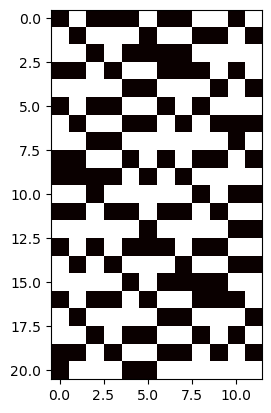

In [13]:
plt.imshow(data_gen(arr, 20), cmap='hot');

Note that the 1s in the chain are black and the 0s are white. To understand the dynamics generated by rule 54, we can think about it as a game where the basic pieces are two consecutive 1s. If the first 1 in the sequence is at an even-index position, then the two 1s move counter-clockwise:

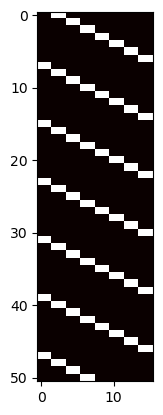

In [16]:
# initializing all-zero sequence and setting 1s on site 2 and site 3
r_mvr = torch.zeros(16) 
r_mvr[2]+=1
r_mvr[3]+=1
plt.imshow(data_gen(r_mvr.long(),50), cmap='hot');

Conversely, if the first 1 in the sequence is placed at a site with an odd index, then the pair moves clockwise:

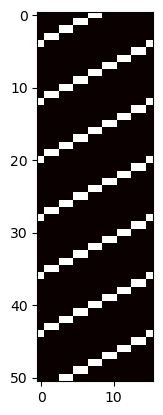

In [15]:
# initializing all-zero sequence and setting 1s on site 7 and site 8
l_mvr = torch.zeros(16)
l_mvr[7]+=1
l_mvr[8]+=1
plt.imshow(data_gen(l_mvr,50), cmap='hot');

To summarize, the pair of 1s moves either left (clockwise) or right (counter-clockwise) based on whether it starts out in an (odd, even) or (even, odd) index position. 

What happens when there are two pairs, one left-moving and one right-moving? Given that they are moving around in a circle, they will have to bump into each other! Let's take a look:


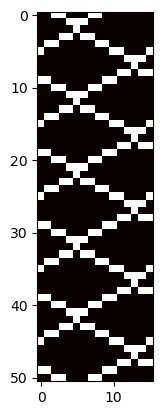

In [17]:
collision = l_mvr + r_mvr
plt.imshow(data_gen(collision.long(),50), cmap='hot');

We observe above that a left- and a right-mover collide by first overalapping and forming a sequence of three 1s, which then coalesce into a single 1 that then splits off into one left- and one right-moving pair of 1s. This is the rule for how our basic pieces collide: they do so elastically!

We have also uncovered what happens when we have a single 1 in our chain - it splits into a left- and a right-mover:

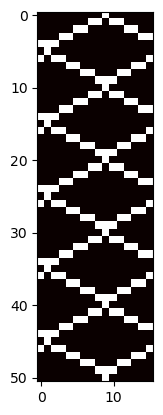

In [19]:
just_one = torch.zeros_like(collision)
just_one[9]+= 1
plt.imshow(data_gen(just_one.long(),50), cmap='hot');

Similarly, we now also know what happens when there are 3 consecutive 1s - they evolve into a single 1 which then splits into a left- and a right-mover:

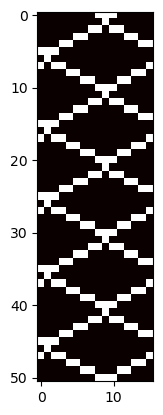

In [22]:
three_ones = torch.zeros_like(collision)
three_ones[8]+= 1
three_ones[9]+= 1
three_ones[10]+= 1
plt.imshow(data_gen(three_ones.long(),50), cmap='hot');

Finally, we can work out what happens when there are four consecutive 1s: three of them are a site of a collision, overlapping with an independent right-mover:

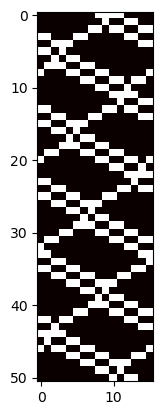

In [26]:
four_ones = torch.zeros_like(collision)
four_ones[8]+= 1
four_ones[9]+= 1
four_ones[10]+= 1
four_ones[11]+= 1
plt.imshow(data_gen(four_ones.long(),50), cmap='hot');

We conclude that in this game, we can always break up any grid/trajectory into the dynamics of the right- and left-movers, and their associated collisions. For instance: 

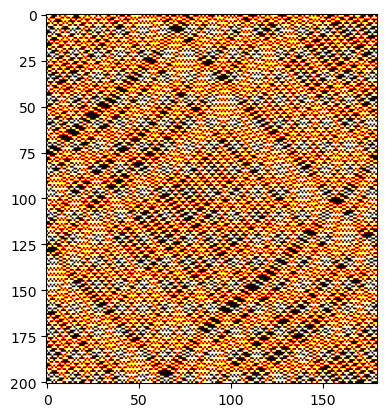

In [27]:
plt.imshow(data_gen(gen_bin(180),200), cmap='hot');

Here we see a pretty pattern of multiple interlaced left- and right-movers propagating and colliding according to the rules described above. Physicists who studied this automaton have a name for the stably propagating left- and right-movers: they are called "solitons". Here, solitons are emergent particle-like entities that propagate around the circle and scatter elastically. Note that the waviness in the pattern above also indicates another interesting property of the soliton scattering: when left- and right-movers bump into each other, they can cause delays in each other's propagation. Also, the number of left- and right-movers is conserved in any CA54 trajectory.

## Why this is a good interpretability toy model:
We see that rule 54 in its local form is quite simple, but say we didn't know it, and simply had access to the kinds of trajectories we have plotted above. If we thought of these trajectories as sequences in the space of binary chains, then could a transformer model learn the rule from it? If it does, then does the model "understand" the rule in terms of the dynamics of solitons like I've described above? These are the questions I want to investigate. My motivation for this setup came out of a discussion surrounding the notion of "features" in the mechanistic interpretability literature. Roughly speaking, the idea is that features are aspects of the data that are relevant to the neural network's ability to model the data. Going back to rule 54- to the physicists who studied this rule, the relevant features are the solitons, so the natural question is whether that is also the case for the trained neural network, which for us will be a transformer.

### Tokenization scheme: 
Say we fix the length of the chain to be 10. Then there are $2^{10}$ possible binary chains. The automaton's dynamics occur between these states. We will therefore find it useful to index the chains and decode chains given an index. For this we introduce encode and decode functions: 

In [ ]:
binary_dict = {np.binary_repr(i, width=10):i for i in range(2**10)}
rev_binary = {s:i for i,s in binary_dict.items()}

def encode(bin_arr):

    lst= bin_arr.tolist()
    s = ''
    for item in lst:
        s+= str(item)
    return binary_dict[s]

def decode(ix):
    st = rev_binary[ix]
    return torch.tensor([int(s) for s in list(st)])


Let's see how they work:

In [ ]:
print( [1,0,0,0,1,0,1,0,1,0],'is encoded as',encode(torch.tensor([1,0,0,0,1,0,1,0,1,0])))

In [ ]:
print(554, 'decodes to',decode(554))

We therefore have an alphabet of $2^{10}$ possible states and the trajectories are sequences of such states. Given this tokenization scheme, we see that there is no way for the transformer to obviously see the local structure of the update rule and thereby learn it exactly. That being said, if the training data contains all possible initial configurations, then the network just needs to memorize $(2^{10})^2$ possible bigrams worth of information. So for the model to actually learn the rule, we will have to withhold some set of initial configurations. I will therefore only train the model on trajectories starting with $2^9$ possible initial states (reminder: this is half of all the possible initial configurations).

Note that the dynamics is such that there is only a small set of states that are reached by any given initial configuration before the updates bring us back to the initial configuration itself. So to really be able to explore the space of all possible states that rule 54 can access, it really matters to cover all possible initial configurations. 

### Network and optimizer settings:

In [ ]:
# Network settings:
block_size = 4
n_embd = 16
n_vocab = 2**10
#for multihead attention, include: n_head = 4
# Optimizer settings:
batch_size = 60
max_iters = 195000
eval_iters = 100
eval_interval = 1000
lr = 3e-3
gamma = 1e-2

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data loader:

We will feed the transformer a sequence of block_size length steps of rule 54 starting with each of $2^{9}$ seeds.

In [ ]:
def get_batch(split,batch_size,block_size,iter):
        def build_block(seed):
                lst = [seed]
                for _ in range(block_size-1):
                    seed = step(seed)
                    lst.append(seed)
                return lst
        if split =='train':
            
            x = torch.stack([torch.tensor([encode(x) for x in build_block(decode(iter%(2**9)))]) for _ in range(batch_size)])
            y = torch.tensor([encode(step(decode(el.item()))) for el in x.view(block_size*batch_size)]).view(batch_size,block_size)
        
        elif split == 'val':
            ix = torch.randint(2**9,2**10,(1,)).item()
            x = torch.stack([torch.tensor([encode(x) for x in build_block(decode(ix))]) for _ in range(batch_size)])
            y = torch.tensor([encode(step(decode(el.item()))) for el in x.view(block_size*batch_size)]).view(batch_size,block_size)
        return x.to(device),y.to(device)

It is worth noting here that our data loader feeds a whole batch of exactly the same sequence! It might seem like this would compel the model to memorize rather than learn to predict the correct next step given an initial condition. We will see however that the model nevertheless generalizes. Givin the model a batch of different examples at a time seems to make learning a lot harder for it. It might be that the model will eventually grok when the data are laid out that way, but I will leave that for future investigation. I will call this method of feeding batches of repeated examples to the model "rote learning."

### Test set and model accuracy:
In addition to leaving out the initial configurations starting from $2^9$ up to $2^{10}$, which I will use as the test set, I will also test the model's ability to generate a sequence of 10 steps to check its actual accuracy. 

In [ ]:
@torch.no_grad()
def estimate_loss(m,gb):
    out= {}
    m.eval()
    for split in ['train','val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,Y = gb(split,batch_size,block_size,k)
            logits, loss = m(X,Y)
            losses[k]= loss.item()
        out[split] = loss.mean()
    m.train()
    return out

@torch.no_grad()
def fail_rate(model):

    model.eval()

    ct = []
    for i in range(2**10):
        context = torch.tensor([[i]],device = device)
        gen=torch.stack([decode(x) for x in model.generate(context,max_new_tokens=10)[0].tolist()])
        targ = data_gen(decode(i),10)
        ct.append(sum(sum(abs(gen-targ))))
        wrong_inits = torch.where(torch.tensor(ct)>0)[0]
        fail_percentage = (len(torch.where(torch.tensor(ct)>0)[0])/1024)*100
        

    model.train()
    return wrong_inits,fail_percentage

### Network:
The network is a 3 layer decoder only transformer with only a single attention head per block. We follow Andrej Karpathy's minGPT very closely:

In [ ]:
torch.manual_seed(155789)
class Attention(nn.Module):
    def __init__(self, n_embd, head_sz):
        super().__init__()
        self.key = nn.Linear(n_embd,head_sz,bias=None)
        self.query = nn.Linear(n_embd,head_sz,bias=None)
        self.value = nn.Linear(n_embd,head_sz,bias=None)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    
    def forward(self,x):
        B,T,C = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        wei = q@(k.transpose(-2,-1))/(C**0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei,dim=-1)
        out = wei@v
        return out

class Block(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.sa = Attention(n_embd,n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = nn.Sequential(nn.Linear(n_embd,4*n_embd),nn.ReLU(),nn.Linear(4*n_embd,n_embd))
    
    def forward(self,x):
        x = x+ self.sa(self.ln1(x))
        x = x+ self.ffwd(self.ln2(x))
        return x

class Net(nn.Module):
    def __init__(self,n_embd,block_size):
        super().__init__()
        self.wte = nn.Embedding(n_vocab,n_embd)
        self.wpe = nn.Embedding(block_size,n_embd)
        #self.blocks = Block(n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd) for _ in range(3)])
        self.lnf = nn.LayerNorm(n_embd)
        self.last = nn.Linear(n_embd,n_vocab)
    
    def forward(self,ix,targets=None):
        B,T = ix.shape
        tok_emb = self.wte(ix)
        pos_emb = self.wpe(torch.arange(T))
        x = tok_emb+pos_emb#(B,T,C)
        x = self.blocks(x)#(B,T,C)->(B,T,C)
        logits= self.last(self.lnf(x))#(B,T,C)@(C,Nvoc)->B,T,Nvoc
        
        if targets == None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits,targets)
        
        return logits, loss
    
    def generate(self,idx,max_new_tokens):

        for _ in range(max_new_tokens):

            idx_cond = idx[:,-block_size:]

            logits,_ = self(idx_cond)

            logits = logits[:,-1,:]#(B,C)
            probs = F.softmax(logits,dim=-1)#(B,C)

            idx_next = torch.multinomial(probs, num_samples=1)#(B,1)
            idx = torch.cat((idx,idx_next),dim=1) #(B,T+1)
        
        return idx
        
model = Net(n_embd,block_size)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-3,weight_decay=1e-2)

In [ ]:
loss_lst = {}
fail_lst = {}

### Training loop: 

In [ ]:
for iter in range(int(max_iters)):

    if iter%eval_interval==0:
        losses = estimate_loss(model,get_batch)
        print(f"step: {iter}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
        loss_lst[iter]=losses['val']
        _,f_percentage = fail_rate(model)
        fail_lst[iter]=f_percentage
        print(f"fail rate: {f_percentage:.4f}")
        

    if iter>7000:
      lr/=10
      gamma*=10
      #lr -> 3e-4

    if iter>50000:
      lr/=3
      # lr -> e-4
    
    if iter>160000:#Need this ensure we end training with a model in an error valley as opposed to on top of a hill
      if f_percentage==0:
            _,f_2 = fail_rate(model)
            if f_2==0:
                break


    xb, yb = get_batch('train',batch_size,block_size,iter)

    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)

    loss.backward()
    optimizer.step()

In [ ]:
l_ys = torch.stack([loss_lst[ix] for ix in range(0,160000,1000)])
l_xs = torch.arange(0,160000,1000)
plt.plot(l_xs,l_ys)
plt.xlabel("# of iterations")
plt.ylabel("X entropy loss on val set") 

In [ ]:
f_ys = torch.tensor([fail_lst[ix] for ix in range(0,160000,1000)])
f_xs = torch.arange(1,160000,1000)
plt.plot(f_xs,f_ys)
plt.xlabel("# of iterations")
plt.ylabel("% of trajectories incorrectly predicted")

In [ ]:
[fail_rate(model) for _ in range(10)]

### Observations:
Note that the spikes in the error correlates with spikes in the validation loss. These plots give us the sense that the training dynamics is such that the model parameters descend into basins of low loss (and error) but then jump over the hills surrounding these basins into valleys of even lower validation loss and error until we get to models that reliably have 0 error on predicting the evolution of all $2^{10}$ initial configurations. 

As an aside, it might help to use a cyclic learning rate schedule to try and smoothen this behavior of the error/loss. 

In [ ]:
#torch.save(model,'model_175k.pt')

In [ ]:
m2 = torch.load('model_175k.pt')

In [ ]:
m2.eval()
[fail_rate(m2) for _ in range(10)]

We can now generate from the model:

In [ ]:
plt.imshow(torch.stack([decode(x.item()) for x in m2.generate(torch.tensor([[2**4-3]]),40)[0]]),cmap='hot')

The model reliably generates more than 10 times as many steps as it was trained on! We can safely say that our trained model is a good stochastic facsimilie of the step() function at this point! 

## Interpreting the model in vocabulary space

 We interpret the action of every block in vocabulary space. First we need to introduce hooks that access the intermediate activations (following: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/):

In [ ]:
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

The hooks I want to attach are to the activations of:

In [ ]:
print(m2.blocks[0],m2.blocks[1],m2.blocks[2])

In [ ]:
te = m2.wte.register_forward_hook(getActivation('tok_emb'))
pe = m2.wpe.register_forward_hook(getActivation('pos_emb'))

In [ ]:
b1 = m2.blocks[0].register_forward_hook(getActivation('block1'))
b2 = m2.blocks[1].register_forward_hook(getActivation('block2'))
b3 = m2.blocks[2].register_forward_hook(getActivation('block3'))

In [ ]:
ln_g = m2.lnf.weight.detach()
ln_b = m2.lnf.bias.detach()

What I will also need is the layer that takes us from embedding space to the vocabulary:

In [ ]:
emb_to_vocab = m2.last.weight.detach()

In [ ]:
emb_to_vocab_b = m2.last.bias.detach()

We would also have to account for the final layer norm to truly be complete in our treatment of the transformer's forward pass, but I will try and forgot doing that for now. Applying m2 to some input will now populate the activations dictionary. 

### Does the model preserve the soliton count even at intermediate stages?
Let us try and find out! Let's take a left mover:

In [ ]:
plt.imshow(data_gen(decode(3),10),cmap='hot')

This trajectory involves only one right moving soliton.

In [ ]:
one_r_mvr = torch.tensor([[768]])
one_evol = m2(one_r_mvr)

In [ ]:
activation

In [ ]:
l_block3 = activation['block3'][0][0]

We see how important the layer norm is to getting the right answer: 

In [ ]:
decode(torch.multinomial(F.softmax(l_block3@emb_to_vocab.T,dim=-1),num_samples=1).item())

In [ ]:
decode(torch.multinomial(F.softmax((ln_g*(l_block3-l_block3.mean())/(l_block3.var()**(0.5))+ln_b)@emb_to_vocab.T,dim=-1),num_samples=1).item())

This function will make generating from a certain block easier:

In [ ]:
def out_from_block(b_tensor):
    return decode(
        torch.multinomial(
            F.softmax((ln_g*(b_tensor-b_tensor.mean())/(b_tensor.var()**(0.5))+ln_b)@emb_to_vocab.T,dim=-1),num_samples=1).item())

As a sanity check, let us make sure that we get the right answer for the final layer form this function: 

In [ ]:
out_from_block(l_block3),step(decode(one_r_mvr[0].item()))

Now let us investigate what happens when we collect the intermediate activations of the embedding and the two previous blocks:

In [ ]:
embs = activation['tok_emb'][0]+ activation['pos_emb'][0]
l_block1 = activation['block1'][0][0]
l_block2 = activation['block2'][0][0]

Now we will generate 50 samples from each of the intermediate activations. Note that the plots below are *not* of trajectories, but 50 re-samplings of the same step! 

In [ ]:
plt.imshow(torch.stack([out_from_block(embs) for _ in range(50)]),cmap='hot')

It seems that the embedding layers already "know" about the right place to put the soliton, for the most part, let us move on to the blocks:

In [ ]:
plt.imshow(torch.stack([out_from_block(l_block1) for _ in range(50)]),cmap='hot')

The first block seems to be a little worse than the embeddings

In [ ]:
plt.imshow(torch.stack([out_from_block(l_block2) for _ in range(50)]),cmap='hot')

In [ ]:
for hook in [te,pe,b1,b2,b3]:
    hook.remove()

By the time we get to the second block however, the model has already made up its mind! Let us try and see what happens when we consider a batch of 20 examples and collect the activations into lists:

In [ ]:
ixs = torch.randint(0,2**10,(20,)).view(-1,1,1)


In [ ]:
te_lst, pe_lst, b1_lst, b2_lst, b3_lst = [], [], [], [], []

We re-register the hooks:

In [ ]:
te = m2.wte.register_forward_hook(getActivation('tok_emb'))
pe = m2.wpe.register_forward_hook(getActivation('pos_emb'))
b1 = m2.blocks[0].register_forward_hook(getActivation('block1'))
b2 = m2.blocks[1].register_forward_hook(getActivation('block2'))
b3 = m2.blocks[2].register_forward_hook(getActivation('block3'))

Then we proceed populate the activation lists:

In [ ]:
for ix in ixs:
    out = m2(ix)
    te_lst.append(activation['tok_emb'])
    pe_lst.append(activation['pos_emb'])
    b1_lst.append(activation['block1'])
    b2_lst.append(activation['block2'])
    b3_lst.append(activation['block3'])
    

In [ ]:
emb_tens = []
for t, p in zip(te_lst,pe_lst):
    emb_tens.append(t[0]+p[0])

b1_tens = []
for b1s in b1_lst:
    b1_tens.append(b1s[0][0])

b2_tens = []
for b2s in b2_lst:
    b2_tens.append(b2s[0][0])

b3_tens = []
for b3s in b3_lst:
    b3_tens.append(b3s[0][0])
    

Let us form a list of the correct next steps for each initial configuration in ixs:

In [ ]:
correct = [step(decode(ix[0].item())) for ix in ixs]

And use this list to give us a sense for the deviation of the prediction made by each block from the correct answer:

In [ ]:
[out_from_block(tens)-ans for tens,ans in zip(emb_tens,correct)]

In [ ]:
[out_from_block(tens)-ans for tens,ans in zip(b1_tens,correct)]

In [ ]:
[out_from_block(tens)-ans for tens,ans in zip(b2_tens,correct)]

So even though two blocks a lot more reliable than just one block, or just the trained embeddings, clearly the third block is doing some necessary computation! 

In [ ]:
[out_from_block(tens)-ans for tens,ans in zip(b3_tens,correct)]

### Cooling down block 2:

It is possible that perhaps our method of sampling is playing a role in how well or poorly the second to last layer is doing. We can give ourselves a knob to determined how "sure" we want to be about the predictions by introducing temperature into the probability distribution from which we are sampling: 

In [ ]:
def out_from_block_beta(log_probs,temp): 
    return decode(
        torch.multinomial(
            F.softmax((1/temp)*(ln_g*(log_probs-log_probs.mean())/(log_probs.var()**(0.5))+ln_b)@emb_to_vocab.T,dim=-1),
            num_samples=1).item())


Let us first see the effect of temperature on the full transformer. Temperature of 1 is basically the same as the default sampling scheme we have been using before:

In [ ]:
[out_from_block_beta(tens,1)-out_from_block(tens) for tens in b3_tens]

Raising the temperature makes the model more uncertain about its predicitons: 

In [ ]:
[out_from_block_beta(tens,3.0)-out_from_block(tens) for tens in b3_tens]

Whereas lowering helps make it more certain in its prediction. To really see the effect of this let us try and "cool down" what comes out of the second block:

In [ ]:
[out_from_block_beta(tens,1.0)-ans for tens,ans in zip(b2_tens,correct)]

In [ ]:
[out_from_block_beta(tens,0.004)-ans for tens,ans in zip(b2_tens,correct)] 

So the temperature doesn't actually improve the second block's performance, but it localises the initial conditions on which it makes an error. To see this, we can run the previous two cells repeatedly and see the differences in which initial condition the model makes a mistake on. 

## Counting solitons

Rule 54 preserves the total number of left and right moving solitons. To the extent to which the trained model mimics rule 54, it too preserves the number of solitons. We can then wonder about the intermediate layers

In [ ]:
def Ps(bin_arr,ix,ud,AB):
    u_d = {'u':1,'d':0}
    a_b = {'A':0,'B':1}
    return bin_arr[ix][a_b[AB]]==u_d[ud]

def rho_r(bin_arr,ix):
    
    term1 =  int(Ps(bin_arr,ix,'u','A') * Ps(bin_arr,ix,'u','B'))
    term2 = int(Ps(bin_arr,ix-1,'d','B')* Ps(bin_arr,ix,'u','A')* Ps(bin_arr,ix,'d','B'))
    term3 = int(Ps(bin_arr,ix,'d','A')* Ps(bin_arr,ix,'u','B')* Ps(bin_arr,(ix+1)%len(bin_arr),'d','A'))

    return term1+term2+term3

def rho_l(bin_arr,ix):
   
    term1 =  int(Ps(bin_arr,ix-1,'u','B') * Ps(bin_arr,ix,'u','A'))
    term2 = int(Ps(bin_arr,ix,'d','A')* Ps(bin_arr,ix,'u','B')* Ps(bin_arr,(ix+1)%len(bin_arr),'d','A'))
    term3 = int(Ps(bin_arr,ix,'d','B')* Ps(bin_arr,(ix+1)%len(bin_arr),'d','B')* Ps(bin_arr,(ix+1)%len(bin_arr),'u','A'))
    
    return term1+term2+term3

rhollst = lambda mt,dims:[np.sum([rho_l(bintwo(mt[j]),ix) for ix in range(int(dims[1]/2))]) for j in range(0,dims[0],int(dims[0]/10))]
rhorlst = lambda mt,dims:[np.sum([rho_r(bintwo(mt[j]),ix) for ix in range(int(dims[1]/2))]) for j in range(0,dims[0],int(dims[0]/10))]

